# Set up 

In [8]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

In [9]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/omitted_data/')

In [10]:
Teusink_ant ='../../../models/Antimony/topologyA-reg2.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.0077414646998453e-15

In [11]:
pt_levels = [0.1, 0.2, 0.3, 0.4,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [12]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

## Leaving out external metabolite data

In [13]:
data01 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_0.1.csv')[fluxes+internal+enzymes]
data02 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_0.2.csv')[fluxes+internal+enzymes]
data03 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_0.3.csv')[fluxes+internal+enzymes]
data04 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_0.4.csv')[fluxes+internal+enzymes]
data05 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_0.5.csv')[fluxes+internal+enzymes]

data15 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_1.5.csv')[fluxes+internal+enzymes]
data3 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_3.csv')[fluxes+internal+enzymes]
data5 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_5.csv')[fluxes+internal+enzymes]
data7 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_7.csv')[fluxes+internal+enzymes]
data100 = pd.read_csv('../../../data/generated_data/topologyA-reg2/topologyA-reg2_10.csv')[fluxes+internal+enzymes]

In [14]:
BMCA_obj01 = antemll.antemll(Teusink_ant, data01, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj02 = antemll.antemll(Teusink_ant, data02, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj03 = antemll.antemll(Teusink_ant, data03, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj04 = antemll.antemll(Teusink_ant, data04, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj05 = antemll.antemll(Teusink_ant, data05, '../../../models/sbml/topologyA_cobra.xml')

BMCA_obj15 = antemll.antemll(Teusink_ant, data15, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj3 = antemll.antemll(Teusink_ant, data3, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj5 = antemll.antemll(Teusink_ant, data5, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj7 = antemll.antemll(Teusink_ant, data7, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj100 = antemll.antemll(Teusink_ant, data100, '../../../models/sbml/topologyA_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


# Running ADVI

In [15]:
def run_BayesInf(BMCA_obj, n_samp=1):
    np.random.seed(SEED)
    random.seed(SEED)

    external = r.getBoundarySpeciesIds()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in data100.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.yn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))

        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 20000 # 45000

        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 9,225.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,251.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,216.3


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 284.67


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = -219.92


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = -571.49


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,004.8


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 13,228


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 29,741


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 66,471


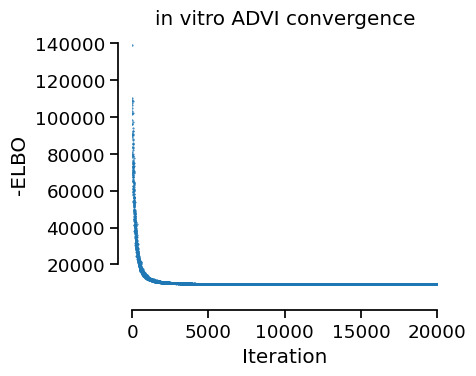

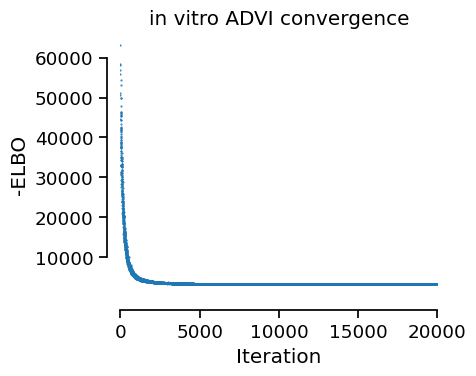

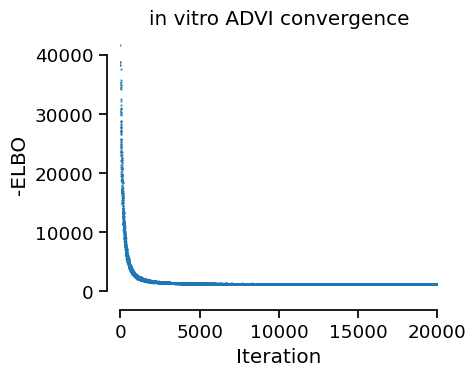

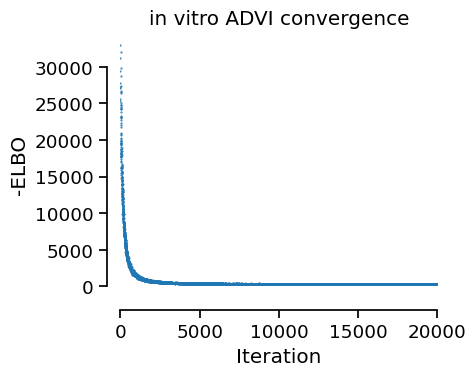

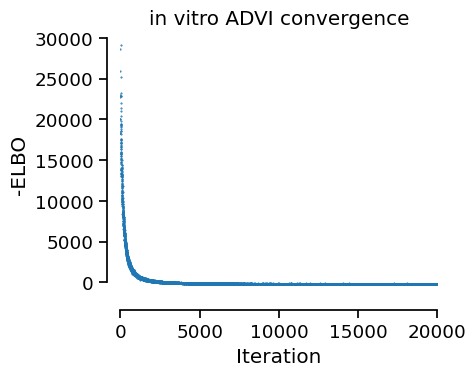

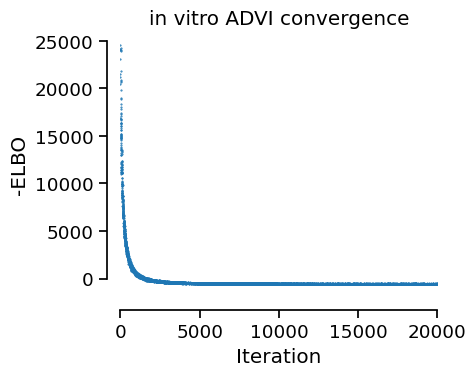

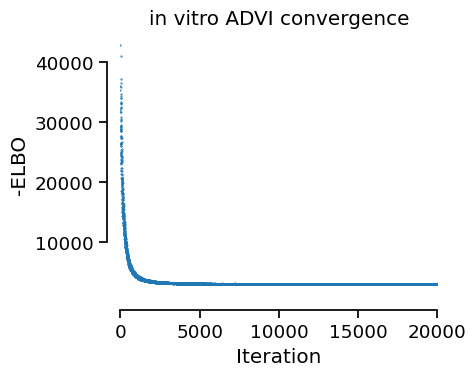

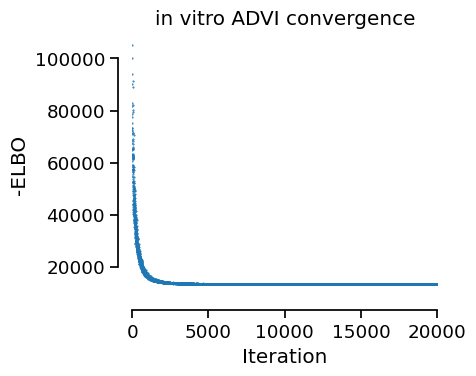

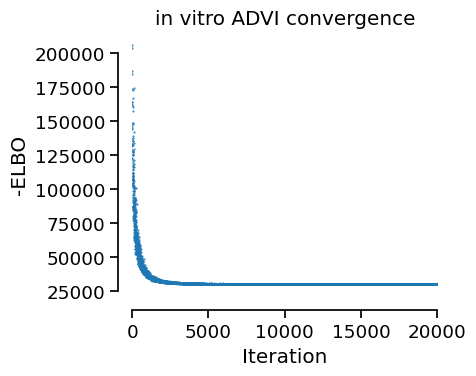

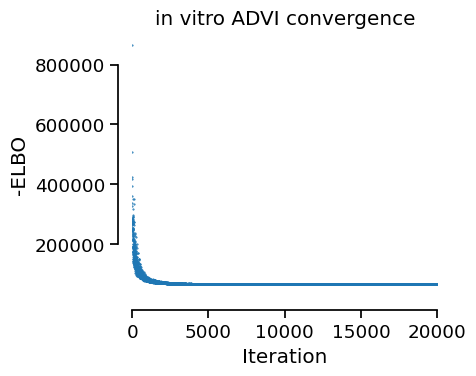

In [16]:
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)
trace05 = run_BayesInf(BMCA_obj05, n_samp=3)

trace15 = run_BayesInf(BMCA_obj15, n_samp=3)
trace3 = run_BayesInf(BMCA_obj3, n_samp=3)
trace5 = run_BayesInf(BMCA_obj5, n_samp=3)
trace7 = run_BayesInf(BMCA_obj7, n_samp=3)
trace100 = run_BayesInf(BMCA_obj100, n_samp=3)
#264 min

### saving trace data

In [17]:
with gzip.open("topologyA-reg2_omitExMet_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [8]:
picklefolder = '../../../data/results/tracePickles-20240718/' # tracePickles-20240718

with gzip.open(picklefolder + 'topologyA-reg2_omitExMet_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [9]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check

In [10]:
med_Ex01_advi = util.get_az_mean(trace01)
med_Ex02_advi = util.get_az_mean(trace02)
med_Ex03_advi = util.get_az_mean(trace03)
med_Ex04_advi = util.get_az_mean(trace04)
med_Ex05_advi = util.get_az_mean(trace05)

med_Ex15_advi = util.get_az_mean(trace15)
med_Ex3_advi = util.get_az_mean(trace3)
med_Ex5_advi = util.get_az_mean(trace5)
med_Ex7_advi = util.get_az_mean(trace7)
med_Ex100_advi = util.get_az_mean(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [11]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                med_Ex01_advi, med_Ex02_advi, med_Ex03_advi, 
                               med_Ex04_advi, med_Ex05_advi, 
                               med_Ex15_advi, med_Ex3_advi, med_Ex5_advi, 
                               med_Ex7_advi, med_Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-reg2_omitFluxes_elasticities.csv')

In [12]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

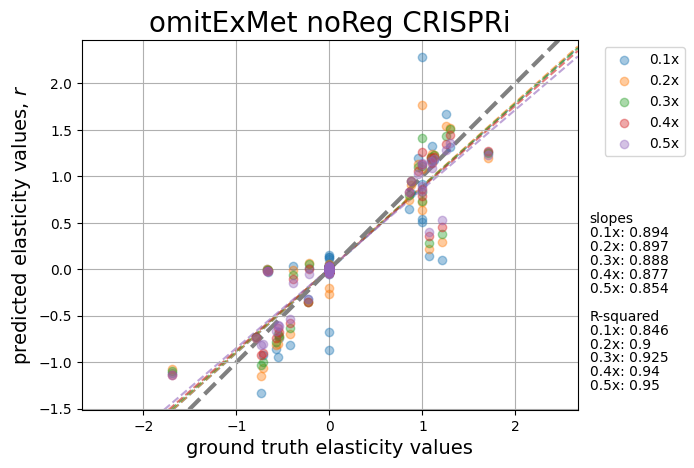

In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('omitExMet reg2 CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.8
line_spacing = 0.15
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[1:6]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[1:6]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

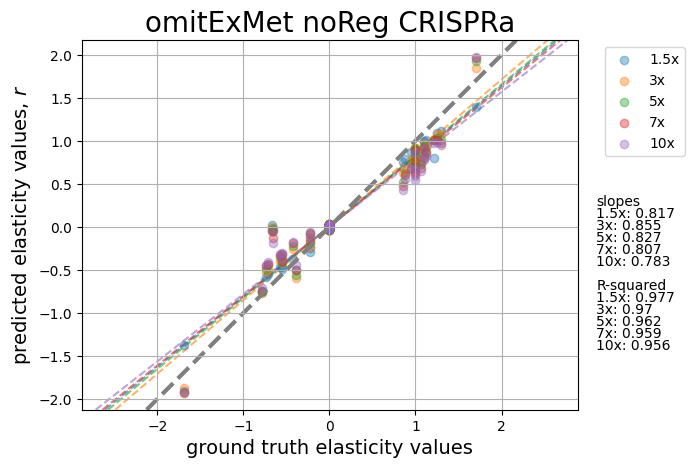

In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('omitExMet reg2 CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 3.1
line_spacing = 0.14
slope_start = 0.25
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+5]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+5]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+5]), slope=e_slopes[i+5], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

In [ ]:
# running ANOVA on differences btw gt and predicted
# elasticities_df = elasticities_df.sub(elasticities_df['gt'], axis=0)
stats.f_oneway(elasticities_df['0.1x'],
                elasticities_df['0.2x'],
                elasticities_df['0.3x'],
                elasticities_df['0.4x'],
                elasticities_df['0.5x'],
                elasticities_df['1.5x'],
                elasticities_df['3x'],
                elasticities_df['5x'],
                elasticities_df['7x'],
                elasticities_df['10x'])

F_onewayResult(statistic=0.1300026868518171, pvalue=0.9989280386260881)

In [15]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt      0.000000
0.1x    0.082939
0.2x    0.065382
0.3x    0.054257
0.4x    0.047026
0.5x    0.041356
1.5x    0.036563
3x      0.040406
5x      0.046046
7x      0.047939
10x     0.050770
dtype: float64

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

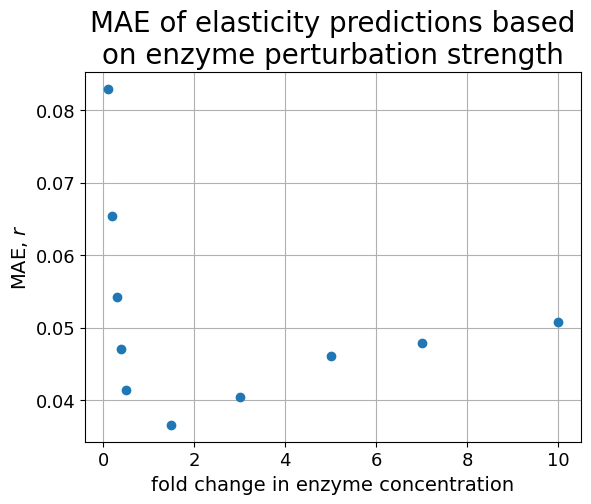

In [22]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
# plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

In [ ]:
MAE.to_csv('topologyA-reg2_omitExMet_MAE.csv')

## Calculating FCCs

In [13]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

### Negative predictions

In [14]:
Ex01_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex02_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj02)['prior']['Ex'])
Ex03_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex04_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj04)['prior']['Ex'])
Ex05_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

In [15]:
priorFCC01 = util.estimate_CCs(BMCA_obj01, Ex01_prior.reshape((16,-1)))
priorFCC02 = util.estimate_CCs(BMCA_obj02, Ex02_prior.reshape((16,-1)))
priorFCC03 = util.estimate_CCs(BMCA_obj03, Ex03_prior.reshape((16,-1)))
priorFCC04 = util.estimate_CCs(BMCA_obj04, Ex04_prior.reshape((16,-1)))
priorFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_prior.reshape((16,-1)))

priorFCC15 = util.estimate_CCs(BMCA_obj15, Ex15_prior.reshape((16,-1)))
priorFCC3 = util.estimate_CCs(BMCA_obj3, Ex3_prior.reshape((16,-1)))
priorFCC5 = util.estimate_CCs(BMCA_obj5, Ex5_prior.reshape((16,-1)))
priorFCC7 = util.estimate_CCs(BMCA_obj7, Ex7_prior.reshape((16,-1)))
priorFCC100 = util.estimate_CCs(BMCA_obj100, Ex100_prior.reshape((16,-1)))


In [16]:
postFCC01 = util.estimate_rep_CCs(BMCA_obj01, med_Ex01_advi.reshape((16,11)), 3, np.diag(BMCA_obj01.en.values / BMCA_obj01.vn.values))
postFCC02 = util.estimate_rep_CCs(BMCA_obj02, med_Ex02_advi.reshape((16,11)), 3, np.diag(BMCA_obj02.en.values / BMCA_obj02.vn.values))
postFCC03 = util.estimate_rep_CCs(BMCA_obj03, med_Ex03_advi.reshape((16,11)), 3, np.diag(BMCA_obj03.en.values / BMCA_obj03.vn.values))
postFCC04 = util.estimate_rep_CCs(BMCA_obj04, med_Ex04_advi.reshape((16,11)), 3, np.diag(BMCA_obj04.en.values / BMCA_obj04.vn.values))
postFCC05 = util.estimate_rep_CCs(BMCA_obj05, med_Ex05_advi.reshape((16,11)), 3, np.diag(BMCA_obj05.en.values / BMCA_obj05.vn.values))

postFCC15 = util.estimate_rep_CCs(BMCA_obj15, med_Ex15_advi.reshape((16,11)), 3, np.diag(BMCA_obj15.en.values / BMCA_obj15.vn.values))
postFCC3 = util.estimate_rep_CCs(BMCA_obj3, med_Ex3_advi.reshape((16,11)), 3, np.diag(BMCA_obj3.en.values / BMCA_obj3.vn.values))
postFCC5 = util.estimate_rep_CCs(BMCA_obj5, med_Ex5_advi.reshape((16,11)), 3, np.diag(BMCA_obj5.en.values / BMCA_obj5.vn.values))
postFCC7 = util.estimate_rep_CCs(BMCA_obj7, med_Ex7_advi.reshape((16,11)), 3, np.diag(BMCA_obj7.en.values / BMCA_obj7.vn.values))
postFCC100 = util.estimate_rep_CCs(BMCA_obj100, med_Ex100_advi.reshape((16,11)), 3, np.diag(BMCA_obj100.en.values / BMCA_obj100.vn.values))

In [17]:
prior_FCCs = [priorFCC01, priorFCC02, priorFCC03, priorFCC04, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


## Evaluating FCC ranking

In [18]:
## ground truth FCC rankings

gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vYAN']

### via Spearman rank coefficients

In [19]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'vYAN', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [20]:
pt_labels = [i+'-prior' for i in pt_labels] + [i+'-post' for i in pt_labels]

In [21]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x-prior,0.246429,0.375951,-0.385270,0.708095
0.2x-prior,0.300000,0.277317,-0.354132,0.753658
0.3x-prior,0.242857,0.383128,-0.385606,0.753198
0.4x-prior,0.250000,0.368846,-0.387260,0.761382
0.5x-prior,0.325000,0.237225,-0.268574,0.790983
1.5x-prior,0.289286,0.295665,-0.273771,0.764087
3x-prior,0.178571,0.524284,-0.365971,0.700375
5x-prior,0.153571,0.584764,-0.542071,0.659480
7x-prior,0.189286,0.499263,-0.427059,0.692593
10x-prior,0.250000,0.368846,-0.332283,0.693012


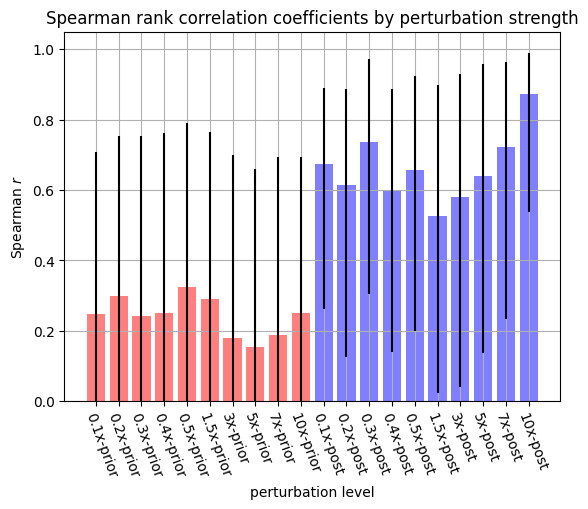

In [22]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']*10 + ['b']*10)
plt.grid()

for i, val in enumerate(spearman_df['r']):
    if val < 0: 
        c ='gray'
    else: 
        c='k'
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color=c)

for i, val in enumerate(spearman_df['r']):
    if val < 0: 
        plt.annotate(round(val, 2), (pt_labels[i], 0.02), size=8, ha='center', rotation=30,rotation_mode="anchor")

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

_=plt.xticks(rotation=-70,ha='left',rotation_mode="anchor")

In [23]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyA_reg2_omitExMet_spr.csv')

### evaluating top 10 rankings

In [24]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'vYAN', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('vYAN') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vYAN')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,...,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
vYAN,,,,,,,,,,,,,,,,,,,,,
1.0,vLIM,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,...,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM
2.0,vWHI,vOSC,vOSC,vOSC,vQUE,vSIE,vTAN,vTAN,vROM,vTAN,...,vOSC,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI
3.0,vALP,vQUE,vQUE,vQUE,vSIE,vQUE,vSIE,vQUE,vTAN,vVIC,...,vNOV,vNOV,vALP,vOSC,vOSC,vOSC,vALP,vALP,vALP,vALP
4.0,vSIE,vUNI,vSIE,vSIE,vUNI,vVIC,vVIC,vROM,vSIE,vUNI,...,vALP,vALP,vNOV,vNOV,vALP,vALP,vOSC,vNOV,vNOV,vNOV
5.0,vNOV,vSIE,vROM,vROM,vVIC,vUNI,vQUE,vSIE,vUNI,vQUE,...,vKIL,vKIL,vOSC,vALP,vNOV,vNOV,vNOV,vOSC,vOSC,vOSC
6.0,vVIC,vROM,vUNI,vUNI,vOSC,vROM,vUNI,vVIC,vQUE,vROM,...,vQUE,vQUE,vKIL,vKIL,vKIL,vQUE,vQUE,vQUE,vQUE,vSIE
7.0,vOSC,vVIC,vVIC,vVIC,vROM,vTAN,vROM,vUNI,vVIC,vSIE,...,vWHI,vZUL,vQUE,vZUL,vQUE,vKIL,vKIL,vKIL,vKIL,vQUE
8.0,vKIL,vNOV,vLIM,vTAN,vTAN,vOSC,vPAP,vPAP,vPAP,vPAP,...,vROM,vROM,vZUL,vQUE,vZUL,vZUL,vZUL,vZUL,vSIE,vKIL
9.0,vTAN,vTAN,vPAP,vPAP,vPAP,vLIM,vLIM,vLIM,vLIM,vLIM,...,vSIE,vSIE,vROM,vROM,vROM,vPAP,vPAP,vROM,vZUL,vZUL


In [25]:
q.to_csv('../../../data/results/rankings/topologyA-reg2_omitExMet_rankings.csv')
rank_df = pd.read_csv('../../../data/results/rankings/topologyA-reg2_omitExMet_rankings.csv')

In [26]:
topTen_df = rank_df[rank_df['vYAN'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,10x-prior,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
0,7,7,7,7,7,7,7,7,7,7,8,7,7,7,7,6,6,6,7,8


In [27]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12, 13], dtype='int64')
Int64Index([10, 12], dtype='int64')
Int64Index([10, 11, 12], dtype='int64')
Int64Index([10, 11, 12], dtype='int64')
Int64Index([10, 11, 12], dtype='int64')
Int64Index([10, 11, 12], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12], dtype='int64')
Int64Index([10, 11], dtype='int64')
